<a href="https://colab.research.google.com/github/raqueeb/nlp_bangla/blob/master/Chap_7_transformers_bert_Bangla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## হাতেকলমে ন্যাচারাল ল্যাঙ্গুয়েজ প্রসেসিং: শুরুর ধারণা

[৭ম অধ্যায়](https://aiwithr.github.io/nlpbook/)

## ট্রান্সফরমার্স মডেল: হাগিংফেস ট্রান্সফরমার্স লাইব্রেরি

সত্যি কথা বলতে আমার এই বুড়ো বয়সে,  আমি যতটা এক্সাইটেড তার বেশিরভাগ এর জন্য  দায় নিতে হবে এই ট্রান্সফরমার্স মডেলকে।  ন্যাশনাল ল্যাঙ্গুয়েজ ল্যান্ডস্কেপ এটা আসলেই পাল্টে দিয়েছে ল্যাঙ্গুয়েজ ভিত্তিক মেশিন লার্নিংকে। ডিপ লার্নিং ফ্রেমওয়ার্ক, যেমন টেন্সরফ্লো এবং পাইটর্চ লাইব্রেরীগুলোর সাথে ট্রান্সফরমারসের ‘বিল্ট-ইন’ ইম্প্লেমেন্টেশন না থাকার ফলে আমাদের একটু কষ্ট হচ্ছে। এর একটাই পথ। এই সংক্রান্ত ‘পিএইচডি’ প্রোগ্রামে ভর্তি হয়ে যাওয়া।

### ট্রান্সফর্মারস এবং হাব

তবে, ইদানিং আরেকটা রাস্তা দেখছি আমরা। সেটা হচ্ছে হাগিংফেসের ট্রান্সফর্মারস লাইব্রেরি। অসাধারণ একটা ইম্প্লেমেন্টেশন বর্তমান ন্যাচারাল ল্যাঙ্গুয়েজ আন্ডারস্ট্যান্ডিং (এনএলইউ) এবং ন্যাচারাল ল্যাঙ্গুয়েজ জেনারেশনে (এনএলজি)। আমাদের সুবিধার জন্য এরা প্রায় একশোর বেশি ভাষায় ৩৫ টার মতন প্রি-ট্রেইন্ড মডেল তৈরি করে রেখেছে আমাদের কাজে। এই ‘প্রি-ট্রেইন্ড ‘ মডেলগুলোকে বুঝতে আপনি হাতে কলমে পাইথন ডিপ লার্নিং বইটা দেখতে পারেন। পুরো বইয়ের  কনটেন্ট অনলাইনে আছে। সবচেয়ে বড় ব্যাপারটা হচ্ছে এই মডেল গুলো সাথে পৃথিবীর সবচেয়ে বড় ডিপ লার্নিং ফ্রেমওয়ার্ক টেন্সরফ্লো এবং পাইটর্চের ভালো ইন্ট্রিগেশন আছে।

### হাগিংফেস কী?

বর্তমানে সবচেয়ে বড় বড় ট্রান্সফরমার্স লাইব্রেরিগুলো বানিয়ে সেগুলো কে সবার মধ্যে ছড়িয়ে দিতে চলে এসেছে হাগিং সেলিং কোম্পানি টা। সবচেয়ে বড় ফিচার হচ্ছে বর্তমানের সর্বশেষ প্রযুক্তি গুলোকে ছেড়ে দেওয়া হচ্ছে আমাদের হাতে।  আমার ল্যাপটপ এবং বাচ্চার গেমিং পিসি মিলিয়ে মাঝারি ধরনের ডিপ লার্নিং মডেল কাজ করাতে গেলে প্রায় 5 থেকে 7 দিন লেগে যায়।  সেখানে এ ধরনের  মডেলগুলো কে  ডাউনলোড সরাসরি ভাবে এখনই।  এর পাশাপাশি গুগোল ক্লাবের জিপিইউ ব্যবহার করতে গেলে 12 ঘন্টার একটা সীমাবদ্ধতা আছে।  সে কারণে এ ধরনের মডেল যেগুলো আগের থেকে ট্রেনিং করা হয়েছে সে গুলোকে ব্যবহার করতে পারছি এই ধরনের প্লাটফর্ম থেকে।

## কার্বন ফুটপ্রিন্ট কমানো

এই হাবের কারণে পুরো পৃথিবী জুড়ে একই ডিপ লার্নিং মডেলকে বারবার ট্রেনিং না করিয়ে পৃথিবীব্যাপী প্রচুর বিদ্যুৎ খরচ এবং কার্বন ফুটপৃন্ট কমে আসছে।  বড় বড় ডাটা সেন্টারে এক ধরনের ডিপ লার্নিং মডেল ট্রেনিং না করিয়ে 1মডেল দিয়েই চালাতে পারছি আমাদের হাতের কাজ ।  এই মডেলগুলো বড় বড় কাজ কাজের জন্য তৈরি করা  হলেও এগুলোকে আমাদের দৈনন্দিন কাজে ব্যবহারের জন্য  অসাধারণ কাজ করে।  এগুলোকে আমরা বলি ডাউনস্ট্রিম কাজ।  গুগল-ফেসবুকের বিশাল বিশাল মডেল আমাদের ছোটখাট টেক্সট ক্লাসিফিকেশন অথবা এন্টিটি রিকগনিশন এর কাজের অসাধারণ ফলাফল দেয়।

### অনেক প্যারামিটার

বড় বড় মডেল যেমন,   BERT, RoBERTa, GPT, GPT-2, XLNet, ইত্যাদি এবং হাগিংফেসের নিজস্ব  DistilBERT, DistilGPT-2 ইত্যাদি সব মডেল কে কল করা যায় মাত্র তিন লাইনের কোড দিয়ে। এ ধরনের মডেলগুলোর এম্বেডিং ব্যবহার করা যায় যেকোনো কোড থেকে। শুধুমাত্র ইন্টারনেট সংযোগ থাকলেই হবে। তবে ইন্টারনেট ছাড়াও এ ধরনের মডেল গুলো চালানো যায়। 

সবচেয়ে বড় ব্যাপার হচ্ছে এ ধরনের বড় বড় মডেলগুলো থেকে বিশেষ করে এই আগে থেকে তৈরি মডেলগুলোকে ব্যবহার করা যায় আমাদের মত কাস্টম কাজে।  আপনি যদি প্রশ্ন উত্তর সেশন,  সেন্টিমেন্ট এনালাইসিস সামারাইজেশন এন্টিটি রিকগনিশন এগুলো এখন খুব সহজ হয়ে গিয়েছে।  যেহেতু ফাকিং ফ্রেন্ডস ট্রান্সফর্মার খুব জনপ্রিয় লাইব্রেরী সে কারণে এগুলো প্রতিনিয়ত আপডেট হচ্ছে পুরো পৃথিবী থেকে।

## কিভাবে মডেলগুলো পাওয়া যাবে?

যেহেতু মডেলগুলো আগে থেকে তৈরি করা,  সে কারণে আমরা ফিলটার ব্যবহার করে এগুলো খুঁজতে পারি। তবে ট্রান্সফরমারের জন্য সবচেয়ে বেশি সাপোর্ট এসেছে পাইটর্চ এর জন্য,  তবে আমরা যারা টেন্সরফ্লো ব্যবহার করি,  তাদের খুব একটা সমস্যা হওয়ার কথা নয়। 

## মডেল কিভাবে এক্সেস করবো?

নিচের কোডটা দেখুন। লাইনের একটা কোড যেটা আপনাকে সাহায্য করবে যেকোনো হাগিংফেস  ট্রান্সফরমার্স মডেল এক্সেস করার জন্য। সামনের উদাহরণে আপনারা দেখবেন কোথায়  এবং কিভাবে আমরা বাংলা মডেল ব্যবহার করব।

```
from transformers import TFAutoModel, AutoTokenizer
model = TFAutoModel.from_pretrained("<মডেলের নাম>")
tokenizer = AutoTokenizer.from_pretrained("<মডেলের নাম>")
```
এবং ব্যাপারটা এতটাই সহজ। তবে আমি চাচ্ছি আপনাদেরকে আরেকটা ফ্রেমওয়ার্কের সাথে পরিচয় করে দিতে - যাতে আপনারা এই ট্রান্সফর্মার মডেলগুলো থেকে আরো অনেক বেশি ‘ডাউনস্ট্রিম’ কাজ পেতে পারেন। 

### ‘কেট্রেইন’ কী?

`ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models.`

এটা ঠিক যে আমরা সরাসরি ট্রান্সফরমারস ব্যবহার করতে পারতাম, তবে সেটা এই বইটাকে আরও বড় করে তুলবে। আর, তাই পাইটর্চ এর সাথে “সিম্পল ট্রান্সফরমার্স” এর মত আরেকটা মেশিন লার্নিং ফ্রেমওয়ার্কের সাথে কাজ করব এখন। এর নাম “কেট্রেইন”, তবে এটা টেন্সরফ্লো এর কমপ্লেক্সিটি লুকিয়ে রাখবে আমাদের কাছ থেকে। 

### “বাংলা বার্ট বেইজ”

 এর পাশাপাশি আমাদের প্রয়োজন বাংলায় কিছু প্রি-ট্রেইনড মডেল, যার বেশ কয়েকটা মডেল আছে হাগিংফেস মডেল হাবে। তবে, আমাদের কাছে আমরা ব্যবহার করব “বাংলা বার্ট বেইজ”। এটা একটা বাংলার প্রি-ট্রেইনড ল্যাঙ্গুয়েজ মডেল, গুগলের ‘বার্ট’ এর মাস্ক ল্যাঙ্গুয়েজ মডেলিং ব্যবহার করে তৈরি করা হয়েছে। এর কর্পাস বাংলা অস্কার এবং বাংলা উইকিপিডিয়া ডাম্প ডাটাসেট থেকে সাহায্য নিয়েছেন।
এই দুটো কর্পাস ব্যবহার করে পুরোটাকে প্রসেস করা হয়েছে বার্ট ফরম্যাটে। এর সাথে, বাংলা এনএলপি প্যাকেজ ব্যবহার করে বাংলা ট্রেনিং ‘সেন্টেন্সপিস’ মডেল  তৈরি করা হয়েছে যার ভোকাবুলারি সাইজ ১ লক্ষর উপরে। এই  ভগবতী এটা আমরা নেব হাগিংফেস মডেল হাব থেকে।

### ১১ কোটি প্যারামিটার

এই ট্রেনিং এর জন্য ব্যবহার করা হয়েছে  গুগল গিটহাবের স্ক্রিপ্ট যা পাওয়া যাবে https://github.com/google-research/bert) লিঙ্কে। এটা একটা আন-কেসড মডেল (উপরের/নিচের কেস নয়) যার মধ্যে ১২ লেয়ার, ৭৬৪ হিডেন লেয়ার, ১২টা অ্যাটেনশন হেড এবং ১১ কোটি প্যারামিটার আছে। এর ১০ লক্ষ ট্রেনিং স্টেপ ট্রেনিং করা হয়েছে গুগলের ক্লাউড টিপিইউ ব্যবহার করে যা দিয়েছে গুগল টেন্সরফ্লো রিসার্চ ক্লাউড। 

## কেট্রেইন ব্যবহার করে হাগিংফেসের ট্রান্সফর্মার্স: টেক্সট ক্লাসিফিকেশন 

আমাদের আগের নিউজ ডাটাসেট  ব্যবহার করব দুটো মডেলের কাজের পার্থক্য বোঝার জন্য।  তবে দুটো মডেলে আমরা একই জিনিস ভিন্ন ভাবে করে দেখাবো যাতে আমরা নতুন জিনিস শিখতে পারি। 

এখানে ক্যাগল থেকে ভিন্নভাবে ডাটা ডাউনলোড করি। 

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "test" # জেসন ফাইল থেকে আইডিটা নিয়ে আসুন
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxx" # আপনার ক্যাগল কী

এল এস টি এম নেটওয়ার্কের মতো এখানেও একই ডাঁটা সেট ব্যবহার করছি। এখানে ডাটাসেটের ভেতরের ফাইলগুলো দেখে নিচ্ছি।  আমরা ব্যবহার করব ডাটা সেটের ভার্সন টু ফাইলটা।

In [2]:
!kaggle datasets files furcifer/bangla-newspaper-dataset

name                  size  creationDate         
--------------------  ----  -------------------  
data/data.json         4GB  2020-10-21 06:09:48  
data_v2/data_v2.json   2GB  2020-10-21 06:09:48  


ক্যাগলের ডাটাসেট ডাউনলোড স্পিড দেখছেন তো? একারণেই  ডাটাসেট হোস্ট করার জন্য আমার পছন্দ ক্যাগল।

In [3]:
!kaggle datasets download furcifer/bangla-newspaper-dataset -f data_v2/data_v2.json

 98% 434M/444M [00:03<00:00, 102MB/s]
100% 444M/444M [00:03<00:00, 132MB/s]


ডাটাসেট ‘এক্সট্রাক্ট’ করে নিচ্ছি আমাদের কাজের সুবিধার্থে।

In [4]:
!unzip data_v2.json.zip

Archive:  data_v2.json.zip
  inflating: data_v2.json            


### ডাটা লোড করছি নতুন অ্যারেতে 

আগের মত দুটো পাইথন লিস্টে আমাদের কনটেন্ট এবং ক্যাটাগরিকে নিয়ে নিচ্ছি।


In [5]:
import json
with open('data_v2.json', encoding='utf-8') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['content'])
    labels.append(item['category'])

একই লেবেল, সেট দিয়ে।

In [6]:
set(labels)

{'bangladesh',
 'economy',
 'education',
 'entertainment',
 'international',
 'life-style',
 'opinion',
 'sports',
 'technology'}

In [7]:
categories = list(set(labels))

In [8]:
categories

['education',
 'opinion',
 'bangladesh',
 'economy',
 'international',
 'technology',
 'entertainment',
 'sports',
 'life-style']

এবার ট্রেইন-টেস্ট স্প্লিট ব্যবহার করছি। একই ডাটাসেট - তবে আলাদাভাবে করিয়ে দেখানো। আপনারা আরেকভাবে করবেন, এটাই নিয়ম। টেস্ট সাইজ ২০%। এখানে লেবেল স্ট্রিং হিসেবেই আছে। আলাদাভাবে ‘ওয়ান-হট এনকোডিং’ করিনি আমরা। দরকার নেই। সে বুঝে যাবে। 

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  sentences, labels, test_size=0.2, random_state=42)

ইনস্টল করে নেই, কেট্রেইন। আমাদের অসাধারণ টুল, বিশেষ করে, ট্রান্সফর্মারস ব্যবহার করার জন্য।

In [10]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 140kB/s 


## কিছু ভিজ্যুয়ালাইজেশন

আমাদের দরকার, এলি৫। সামনে দেখবেন বিশেষ করে এক্সপ্লেইন এর ক্ষেত্রে।

In [11]:
!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-es1uh512
Successfully built eli5


### ধাপ ১: ডাটাকে প্রি-প্রসেস এবং ট্রান্সফর্মারস মডেল তৈরি

আমাদের কাজ হচ্ছে টেক্সট ক্লাসিফিকেশন,  ইমপোর্ট দুটো জিনিসকে।


In [12]:
import ktrain
from ktrain import text

কেট্রেইনে আমাদের Transformer হচ্ছে হাগিংফেইস ট্রান্সফর্মারস লাইব্রেরির একটা  অ্যাবস্ট্রাকশন লেয়ার। একে আমরা “ইনস্ট্যান্টসিয়েট” করছি - সেই মডেলের নাম এবং সিকোয়েন্স লেন্থ দিয়ে। বার্ট ভিত্তিক মডেলগুলোর সর্বোচ্চ সিকোয়েন্স লেন্থ সাধারণত ৫১২ হয়। এখানে ৫০০ টোকেনের নিচের কনটেন্টকে প্যাডিং করে দেবে। এর পাশাপাশি যেই কনটেন্টগুলো ৫০০ টোকেনের বেশি, সেগুলোকে কেটে দেবে। 

মনে আছে আমাদের বাংলা ট্রান্সফর্মার্স মডেলের কথা? সেটাকে নিয়ে নিচ্ছি text.Transformer দিয়ে। এখানে আলাদা করে “ক্লাস_নেম” আর্গুমেন্টকে ট্রান্সফর্মারস কনস্ট্রাকটরে পাঠানোর দরকার নেই। যদি লেবেল ‘ওয়ান-হট এনকোডিং’ হতো, তাহলে সেটার প্রয়োজন হতো। 

### মডেল ফাইল (যেকোন একটা)

আমাদের এখানে বার্ট এবং ডিস্টিল-বার্ট বলে দুটো মডেলকে ব্যবহার করার চেষ্টা করেছি। বার্ট, অর্থাৎ বাইডারেশনাল এনকোডার রিপ্রেজেন্টেশন ফ্রম ট্রান্সফরমার্স, যা সরাসরি এসেছে গুগলের রিসার্চারদের কাছ থেকে। এটাতে সুবিধা হচ্ছে আমাদের জনপ্রিয় অ্যাটেনশন মডেলে টেক্সট ট্রেনিং করার সময় আগে যেভাবে আমরা বাঁ দিক থেকে ডান দিকে যেতাম, সেখানে এখন বাঁ দিক থেকে ডান দিকে এবং ডানদিক থেকে বাঁদিকে দু'ধরনের ট্রেনিং করানো সম্ভব হচ্ছে মডেলের দক্ষতা বাড়াতে। এখানে মাস্ক ইনপুট ব্যবহার করা হচ্ছে যেহেতু বাইডাইরেকশন ট্রেনিং আগে অসম্ভব ছিল। বাক্যের সিকোয়েন্স বার্ট এ ফিড করানোর আগে একটা নির্দিস্ট সংখ্যক শব্দকে মাস্ক মানে ঢেকে দেয়া হয় মাস্ক টোকেন দিয়ে - যাতে সে আসল শব্দকে প্রেডিক্ট করতে পারে। এই প্রেডিকশনটা আসে বাক্যের অন্যান্য শব্দগুলোর কন্টেক্সট থেকে - যেগুলোকে ঢেকে দেওয়া হয়নি এবং সেগুলোর সিকোয়েন্স থেকে।
   

## বার্ট এবং ডিস্টিল-বার্ট

সেই বার্টকে ট্রেনিং করাতে গিয়ে যে সময় লাগে, সেখানে দক্ষতা নিয়ে এসেছে ডিস্টিল-বার্ট। আমরা দুটোই করে দেখব।

এখানে গুগলের ডকুমেন্টেশন কি বলছে? 

`As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).`

নামেই কাজে পরিচয়। বার্ট মডেলের পরিশুদ্ধ ভার্সন হচ্ছে এই ডিস্টিল বার্ট। আসল মডেল থেকে ৪০% প্যারামিটার কমিয়ে একে চালানো যায় প্রায় ৬০% দ্রুতগতিতে। সবচেয়ে বড় ব্যাপার হচ্ছে এতে আসল বার্ট মডেলের ৯৫% পারফরম্যান্স রাখা যায়। ডকুমেন্টেশন কি বলছে?

`The DistilBERT model is Smaller, faster, cheaper, lighter: Introducing DistilBERT, a distilled version of BERT, and the paper DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.`


In [ ]:
# MODEL_NAME = 'sagorsarker/bangla-bert-base'
# t = text.Transformer(MODEL_NAME, maxlen=500)

In [13]:
MODEL_NAME = 'neuralspace-reverie/indic-transformers-bn-distilbert'
t = text.Transformer(MODEL_NAME, maxlen=500)

### ডাটাসেটের প্রি-প্রসেসিং

আমাদের ট্রেনিং এবং ভ্যালিডেশন ডেটাকে আলাদা করে প্রি-প্রসেস করতে হবে। এখানে একটু সময় লাগবে, দুই স্টেজে ৪০ মিনিট এবং ২০ মিনিট - গুগল কোলাবে জিপিইউ সেট করে। এখানে বার্ট প্রি-ট্রেইনড মডেল যেই ফরম্যাটে ট্রেনিং এবং ভ্যালিডেশন ডাটা ‘এক্সপেক্ট’ করছে - আমরা সেই ফরম্যাটেই তৈরি করে দিচ্ছি।


In [14]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 268
	95percentile : 669
	99percentile : 1079


Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 269
	95percentile : 669
	99percentile : 1075


### তৈরি করি মডেল

আমরা এখানে একটা ক্লাসিফায়ারকে ডিফাইন করব যার মধ্যে প্রি-ট্রেইনড ওয়েট থাকবে। এর পাশাপাশি, দৈবচয়নের ভিত্তিতে শেষ লেয়ারের ওয়েটগুলোকে দেয়া হলেও সেগুলোকে ফাইন টিউন করা যাবে। 


In [15]:
model = t.get_classifier()

আমাদের মডেল এবং ডাটাকে ঢুকিয়ে দিচ্ছি কেট্রেইনের লার্নার অবজেক্টে। এটা একটা কেট্রেইন লার্নার অবজেক্ট র্যাপার, এখানে ট্রান্সফর্মার্স লাইব্রেরির জন্য তৈরি করে নিচ্ছি। এটা আমাদেরকে সাহায্য করবে খুব তাড়াতাড়ি  মডেলকে ট্রেনিং  করাতে যাতে সে প্রেডিকশন করতে পারে নতুন ডাটার উপরে। 
এখানে ট্রেনিং এর সময় মেমোরি বেশি ব্যবহার করলে ‘ব্যাচ সাইজ’ কমিয়ে আনতে পারেন। সেটাতে সমস্যা হলে কনটেন্টের ‘ম্যাক্সিমাম লেন্থ’ প্যারামিটার কমিয়ে আনতে পারেন আগের ধাপে।

In [16]:
# ট্রেনিং করে নিচ্ছি
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

### ধাপ ২: (শুধুমাত্র দেখার জন্য) একটা ভালো লার্নিং রেট এস্টিমেট 

(শুধুমাত্র, মডেলের কাজ দেখার জন্য -  বেশি সময় লাগলে এই ধাপটা বাদ দিতে পারেন)
মডেলের একটা ভালো লার্নিং রেট দেখতে চাই আমরা সবাই। তবে, এতে সময় লাগে বেশ খানিক। 


simulating training for different learning rates... this may take a few moments...
Train for 54462 steps
21512/54462 [==========>...................] - ETA: 2:11:59 - loss: 0.5840 - accuracy: 0.8369

done.
Visually inspect loss plot and select learning rate associated with falling loss


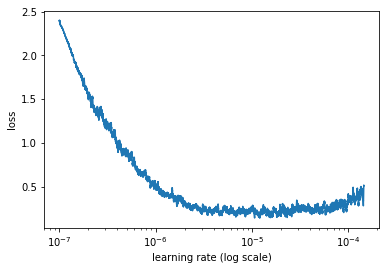

In [ ]:
%matplotlib inline
learner.lr_find(show_plot=True, max_epochs=1)

এই মডেলকে ট্রেইন এবং বিল্ড করতে যে সময় লাগে, সেখানে এভাবে সেভ করে করে আগাতে পারি। না হলে এক ইপকেই ১২ ঘন্টা। গুগল কোলাবে, ১৩ জিবি জিপিইউ এর ১২ জিবি নিয়ে থাকে পুরো সময়। আর কম তো ক্র্যাশ করে না মডেলগুলো!

In [18]:
# preproc = t
# save model and Preprocessor instance after partially training
# ktrain.get_predictor(model, preproc).save('/tmp/my_predictor')

### ধাপ ৩: মডেল ট্রেনিং (লম্বা সময়)

এখানে একটু পড়ে নেয়া যায়। গুগলের রিসার্চ পেপার অনুযায়ী, ‘বার্ট’ বেসড মডেলের জন্য অর্থাৎ ট্রান্সফর্মার ভিত্তিক মডেলগুলো ভাল কাজ করে যখন লার্নিং রেট 2e-5 এবং 5e-5 এর মধ্যে থাকে। তবে আমরা নিচে সেই লার্নিং রেট ফাইন্ডার দিয়ে দেখবো গুগলের সাথে আমাদের ফাইন্ডিং প্রায় কাছাকাছি যায়।  এখানে দুই পক্ষের কথা বলছি।  এর বেশি গেলে কয়েক তার পিসির সামনে বসে থাকতে হবে। সত্যি বলছি। এই বই লেখতে যে কতো রাত নষ্ট হয়েছে আমার তবে, এগুলো নষ্ট নয়, বরং ইনভেস্টমেন্ট।

আমাদের ট্রেনিংয়ের জন্য এখানে “ফিট ওয়ান সাইকেল” (https://arxiv.org/abs/1803.09820) মেথড ব্যবহার করব কেট্রেইনে যা এই রিসার্চ পেপারকে ইমপ্লিমেন্ট করছে। এটার ধারণা সবচেয়ে আগে দিয়েছেন লেসলি স্মিথ। 

লার্নিং রেট শুরুতে একটা বড় সময় নেয় শেখার জন্য, যেটা আস্তে আস্তে কমে অর্থাৎ “ডিকে পিরিয়ড” আসতে থাকে শেষের দিকে। ট্রান্সফরমার্স বেইজড মডেলের জন্য এটা ভালোভাবে কাজ করে।

দুটো ইপক নেই। গুগল কোলাবে ১২ x ২ অর্থাৎ ২৪ ঘন্টা! তবে নিজের জিপিইউ থাকলে চারটা ইপক সাইকেল নিতে পারেন ভালো অ্যাকুরেসি পাবার জন্য। 


In [ ]:
learner.fit_onecycle(8e-5, 2)



begin training using onecycle policy with max lr of 8e-05...
Train for 54463 steps, validate for 2553 steps
Epoch 1/2
54463/54463 [==============================] - 14072s 258ms/step - loss: 0.2056 - accuracy: 0.9349 - val_loss: 0.2718 - val_accuracy: 0.9184
Epoch 2/2
54463/54463 [==============================] - 14112s 259ms/step - loss: 0.2209 - accuracy: 0.9332 - val_loss: 0.1923 - val_accuracy: 0.9389


### ধাপ ৪: মডেল ইভ্যালুয়েশন, কেমন করছে মডেল?

আমাদের মডেলের কনফিউশন মাট্রিক্সটা একটু দেখি।  সবগুলো ক্লাসকে ভিত্তি করে এই কনফিউশন মাট্রিক্সটা তৈরি করা হয়েছে। এখানে precision, recall, f1-score, এবং supportকে আলাদাভাবে দেখানো হয়েছে।


In [ ]:
learner.validate(class_names=t.get_classes())

যেই ক্লাসটাতে আমরা সবচেয়ে বেশি খারাপ করেছি।

In [ ]:
learner.view_top_losses(n=1, preproc=t)

### ধাপ ৫: নতুন এনভায়রনমেন্টে মডেলের প্রেডিকশন

এখন আসি প্রেডিকশনে। preproc=t অর্থ হচ্ছে text.Transformer এর আউটপুট। এটা আমাদের প্রিপ্রসেসিং (যেমন., preproc = text.Transformer('bert-base’) হতে পারে। এখানে প্রেডিক্টর অবজেক্টকে ‘ইনস্ট্যান্টশিয়েট’ করছি যাতে নতুন ডাটা সে প্রেডিক্ট করতে পারে। 


In [21]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

গুগল কোলাবে ট্রেনিং করতে গেলে আমাদের মডেলটা কোলাবের ভার্চুয়াল মেশিনেই থেকে যায়। ফলে এটাকে আমাদের গুগল ড্রাইভে সেভ করে রাখা বুদ্ধিমানের কাজ। 

মাউন্ট করে নেই আমাদের ড্রাইভ। এখানে একটা অথেনটিকেশন লিংক ব্যবহার করে আমাদেরকে কানেক্ট করে নিতে হবে।

In [22]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## গুগল ড্রাইভে মডেল সেভ

মডেলকে সেভ করে নিচ্ছি দুটো ফরম্যাটে। প্রথমটা কেট্রেইন, যেটা কেরাস স্টাইল, পরেরটা ট্রান্সফরমার্স স্টাইল। যখন যেটা লাগে। 

লিংক দেখে বুঝেছেন, মডেলকে আমরা সেভ করছি গুগল ড্রাইভে। তবে শুরুতে গুগল ড্রাইভকে মাউন্ট করে সব ডিরেক্টরি দেখতে পারেন।

আমাদের প্রেডিক্টরকে সেভ করে রাখা দরকার - বিশেষ করে বড় ডাটাসেটগুলোর ট্রেনিংয়ের সময় অনেক বেশি লাগছে। আমাদের মডেল এবং প্রি-প্রসেসরের ইনস্ট্যান্স সেভ করে রাখা দরকার ‘পার্শিয়াল’ ট্রেনিংয়ের পরে।

প্রথমটা কেট্রেইন, এটা দিয়েও মডেল সেভ করতে পারেন। এটা আমাদের জানা দরকার।

পরেরটা ট্রান্সফরমার্স। যেটা পরে লাগতে পারে।



In [23]:
# টেন্সরফ্লোতে কিভাবে মডেল সেভ করি?
# model.save('/content/gdrive/My Drive/Colab Notebooks/saved_model/my_model')

In [24]:
# কেট্রেইন দিয়ে সেভ করা
predictor.save('/content/drive/MyDrive/Colab Notebooks/saved_model/bangla_news_predictor_kt')
# ট্রান্সফরমার্স এপিআই দিয়ে সেভ করি
learner.model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/saved_model/bangla_news_predictor')


মডেল দুটো দেখে নেই আমাদের গুগল ড্রাইভে। একটাতে তিনটা আরেকটাতে দুটো ফাইল।

In [25]:
!ls -alh '/content/drive/MyDrive/Colab Notebooks/saved_model/bangla_news_predictor_kt'

total 628M
-rw------- 1 root root  902 Dec 15 10:17 config.json
-rw------- 1 root root 628M Dec 15 10:17 tf_model.h5
-rw------- 1 root root 3.0K Dec 15 10:17 tf_model.preproc


In [26]:
!ls -ahl '/content/drive/MyDrive/Colab Notebooks/saved_model/bangla_news_predictor'

total 628M
-rw------- 1 root root  902 Dec 15 10:17 config.json
-rw------- 1 root root 628M Dec 15 10:17 tf_model.h5


## মডেলের সামারি

এখানে কয়টা লেয়ার দেখছেন?

In [27]:
learner.model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  164396544 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  6921      
Total params: 164,403,465
Trainable params: 164,403,465
Non-trainable params: 0
_________________________________________________________________


শুরু হলো আমাদের প্রেডিকশন। কেমন মনে হচ্ছে? আগের এলএসটিএম মডেলের কাছে? আমার ধারণা, ট্রান্সফরমার্স মডেল ভালো কাজ করছে।


In [28]:
predictor.predict('বাংলাদেশে নদ-নদীগুলো ছড়িয়ে আছে জালের মতো। ঐতিহাসিকভাবেই এই অঞ্চলের নদ-নদীর গতি–প্রকৃতি ও প্রবাহ জটিল।')

'opinion'

## মডেলের প্রেডিকশন এবং তার এক্সপ্লেনেশন

আমাদের প্রেডিক্টরের কাছে কন্ট্রিবিউশন এবং ফিচারের  ধারণা চাচ্ছি। সেটাই ‘এক্সপ্লেইন’ এখানে। বেশ ভালো রেসপন্স। এখানে আমরা এলি৫ এবং লাইম লাইব্রেরি ব্যবহার করেছি পুরো ব্যাপারটাকে আরও গুছিয়ে আনার জন্য। আমাদের এ ধরনের অনেক কাজ আসছে সামনে। ‘নেমড এনটিটি রিকগনিশন’ নিয়ে কথা বলবো ভিডিওতে। হাগিংফেসের সাইটে ‘এনটিটি রিকগনিশন’ নিয়ে বেশি কিছু এপিআই আছে - যা দিয়ে শুরু করতে পারেন। এখানে হাইলাইট শব্দগুলো মানে হচ্ছে - এই পুরো ব্যাপারটা তারা মেনে নিচ্ছে ক্লাসের ইনটুইশনের সাথে। 

তবে প্রেডিক্টরের ‘এক্সপ্লেইন’ ব্যাপারটাকে ঠিক মতো কাজ করানোর জন্য আমাদেরকে এলি৫ এর আগে দেখানো ফর্কড ভার্সনটা ব্যবহার করা যেতে পারে।  


In [29]:
predictor.explain('বাংলাদেশে নদ-নদীগুলো ছড়িয়ে আছে জালের মতো। ঐতিহাসিকভাবেই এই অঞ্চলের নদ-নদীর গতি–প্রকৃতি ও প্রবাহ জটিল।')

In [30]:
predictor.predict('বাংলাদেশ টেলিভিশনে গান হয়, সংস্কৃতিকে তুলে ধরতে হবে আমাদের।')

'entertainment'

In [31]:
predictor.predict_proba('বাংলাদেশে টেলিভিশনে গান হয়, সংস্কৃতিকে তুলে ধরতে হবে আমাদের।')

array([0.02280626, 0.0014308 , 0.00193409, 0.94940805, 0.01303796,
       0.0046582 , 0.003165  , 0.00179799, 0.00176161], dtype=float32)

In [32]:
predictor.predict('বাংলাদেশে ফুটবল খুব বেশি খেলা হয়, ক্রিকেট কম নয়।')

'opinion'

In [33]:
predictor.explain('শিক্ষা মন্ত্রণালয়ে এমন প্রস্তাব দিয়েছে ছাত্রছাত্রীদের বই বিতরণ করার জন্য সব শিক্ষাপ্রতিষ্ঠান এবং বিদ্যালয়গুলোকে দিকনির্দেশনা দেওয়া হবে।')

In [34]:
!ls -alh '/content/gdrive/My Drive/Colab Notebooks/saved_model/bangla_news_predictor_kt'

ls: cannot access '/content/gdrive/My Drive/Colab Notebooks/saved_model/bangla_news_predictor_kt': No such file or directory


ট্রান্সফর্মারস দিয়ে আবার ‘রিলোড’ করে দেখতে পারেন। আমাদের সবদিক দিয়ে জেনে আগাতে হবে।

In [36]:
from transformers import *
model = TFAutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/saved_model/bangla_news_predictor')
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

কেট্রেইন দিয়েও রিলোড করে দেখি তাহলে।

In [38]:
reloaded_predictor = ktrain.load_predictor('/content/drive/MyDrive/Colab Notebooks/saved_model/bangla_news_predictor_kt')

রিলোডের পর আবার প্রবাবিলিস্টিক প্রেডিকশন দেখি। এর অর্থ হচ্ছে, কাজ চলছে। মডেলকে নতুন করে রিলোড করে চলছে। তবে, পুরো মডেলকে সেভ করে রাখবেন গুগল ড্রাইভে, স্পেস থাকলে। আমার ধারণা এটা ৭০০ মেগাবাইট হতে পারে সর্বোচ্চ।

In [39]:
reloaded_predictor.predict_proba('বঙ্গবন্ধু টি–টোয়েন্টি কাপে কাল জেমকন খুলনার হয়ে খেলার ম্যাচে ৪ ওভারে ২৮ রানে ১ উইকেট নেন মাশরাফি বিন মুর্তজা।')

array([3.5018922e-04, 4.5625397e-04, 1.3120747e-04, 1.1196788e-03,
       7.3227519e-04, 6.0426974e-04, 2.4903766e-04, 9.9611712e-01,
       2.4014582e-04], dtype=float32)

আমাদের ক্লাসগুলো আবারো দেখি। আপনাদের কি মনে হচ্ছে এই ট্রান্সফর্মারস মডেলের ব্যাপারে? অসাধারণ তাই না?

In [40]:
reloaded_predictor.get_classes()

['bangladesh',
 'economy',
 'education',
 'entertainment',
 'international',
 'life-style',
 'opinion',
 'sports',
 'technology']

In [41]:
predictor.explain('ডিজিটাল বাংলাদেশ গড়ার পরিকল্পনার অংশ হিসাবে ই-কমার্সে দক্ষ জনবল বৃদ্ধি ও কর্মসংস্থান সৃষ্টি করার লক্ষ্যে বাণিজ্য মন্ত্রণালয়ের ‘ই-বাণিজ্য করবো নিজের ব্যবসা গড়বো’ প্রকল্পের আওতায় দেশব্যাপী ই-কমার্স বিষয়ক প্রশিক্ষণ পরিচালিত হচ্ছে। চতুর্থ শিল্প বিপ্লবের চ্যালেঞ্জ মোকাবেলায় ই-কমার্সে দক্ষ জনবল আমাদের অর্থনীতির চাকাকে সচল রাখবে। ডিজিটাল কমার্সকে শক্তিশালী করার জন্য তৈরিকৃত ‘বাংলাদেশ ডিজিটাল কমার্স পলিসি ২০১৮’ এর আওতায় বাণিজ্য মন্ত্রণালয় ই-কমার্স প্রতিষ্ঠানসমূহকে নীতিসহায়তা প্রদান অব্যাহত রেখেছে।বাণিজ্যমন্ত্রণালয় বলছে, বর্তমান পরিস্থিতিতে ই-কমার্সের গুরুত্ব অপরিসীম। সামাজিক দূরত্ব বজায় রেখে সাধারন মানুষের নিকট ওষুধ ও অন্যান্য অত্যাবশ্যকীয় পণ্য পৌছে দেয়ার দায়িত্ব পালন করছে ই-কমার্স। বাণিজ্য মন্ত্রণালয়ের প্রত্যক্ষ উদ্যোগে ই-কমার্স অ্যাসোসিয়েশনের সহযোগিতায় এ বছর আম মৌসুমে অন-লাইন আম মেলার আয়োজন করা হয়েছিল এবং এই কর্মসূচি বহুল প্রশংসিত হয়েছিল। বর্তমানে ই-কমার্সের মাধ্যমে ভোক্তাসাধারণের মধ্যে ন্যায্যমূল্যে টিসিবির পেয়াজ বিক্রয় কার্যক্রম সফলভাবে চলমান রয়েছে। ভবিষ্যতে এর পরিধি বাড়ানোর পরিকল্পনা ইতোমধ্যে গ্রহণ করা হয়েছে।')

## ট্রান্সফরমার্স মডেলের হিডেন স্টেট

এটা একটা টুপল, সেটার শেপ দেখা যাবে এখানে।

৭৬৪ হচ্ছে DistilBERT মডেলের হিডেন ইউনিটের সংখ্যা।

In [42]:
from transformers import *
import tensorflow as tf
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = TFAutoModel.from_pretrained('/content/drive/MyDrive/Colab Notebooks/saved_model/bangla_news_predictor')
input_ids = tf.constant(tokenizer.encode("আমরা বাংলায় কথা বলি"))[None, :]  
outputs = model(input_ids)
last_hidden_states = outputs[0] 
print(last_hidden_states.numpy().shape)

(1, 7, 768)


তবে আমরা যেই মডেলই ব্যবহার করিনা কেন, এর পেছনের লার্নার অবজেক্ট আসলে একটা টেন্সরফ্লো কেরাস মডেল।  এখানে কেট্রেইন র্যাপার হিসেবে কাজ করছে।  আমাদের লার্নার মডেলের সামারি দেখেছিলাম উপরে। 